# Project Milestone 2

## How we store and manage the data

## Why do we need a database and where to run it?

When we looked at this dataset, we saw that it would fit very well in a traditional relational database, so we explored this option because leveraging SQL to extract information from the dataset should help us achieve our goals more efficiently.

Several members of the team had also not access to a computer powerful enough and with enough disk space to work efficiently, so we use an old compute server from the CERN we have. They phase out old hardware from time to time and if you're lucky you can buy cheap old but still powerful hardware. The one we use is a high density compute server from 2014 with four nodes each having 64Gb of ram / 24 cores / 2x 2TB hard drives we got for 50 frs. We only use one node because SQL databases usually don't or are hard to cluster, electricity isn't free (but still cheap in our case), we don't have the required switch and cables to build a performant cluster network as standard 1 Gbit Ethernet would probably be a bottleneck and we wanted to store the database on a 512GB NVME ssd that was unused after an upgrade. On the node, we installed proxmox using ZFS for the storage and we run the database inside a container. This has two main advantages:
- ZFS compress partially empty database pages using lz4, we saw disk space saving of up to 40% between the size of a table reported by postgres and its actual size on disk. Furthermore this compression is lightweight in term of CPU usage.
- The ability to make almost free snapshots of the database after the initial data import and pre-processing. If something goes wrong we can go back to a previous known good state because ZFS stores modifications after a snapshot as a diff, so in our case the snapshots are almost free because we query the dataset without modifying it.

## Database choice and configuration
We first went with mariadb because this is what we knew best and phpMyAdmin is a nice tool to explore the dataset and run queries but as we loaded the first part of the dataset, we noticed that mariadb didn't make use of more than one core per query. This is because its engine InnoDB is optimised for web applications that execute many small (1000s of rows) queries so we went with postgres that uses parallel query plans when possible. The installation was relatively straightforward but we had a lot of trouble to find a good tool to query the database and explore the dataset. We finally went with datagrip from jetbrains because it was easy to use for us and fast.

We used [pgtune](https://pgtune.leopard.in.ua/) as a starting point to tune postgres for a data wharehouse usage. This, among other things, tells postgres how many workers it can create to answer queries, the cost of getting data from the disk (huge difference between ssd and hdd) and how much data should be expected to fit in ram.

## Data import
To load the data in the database, we first created one table per csv file with the smallest correct data types (float32, int32 or int64 for numbers, varchar(11) for video_id...) for each column and then used pandas with an SQL connector that read the data in chunks and put it as is in the DB.

For the tags of the file `video_metadata` we created two extra tables: one table for the tags that contains tuples `(tag_id, tag)` and the second that contains tuples `(tag_id, video_id)` to be able to query the tags efficiently. Tags are not repeated in the tags table, to do so during import we mapped the tags to an ID using a hashmap. With postgres we could have stored the tags as an array but this would have made queries like how often is a tag used much less efficient.

### Post import optimisations

We created indexes for all columns that can uniquely identify a row (eg. `video_id`) or select all rows that belong to a group (eg. `channel_id` in `video_metatdata`). We used btree indexes because of the deduplication feature available since postgres 13: each value that appears multiple times will only be stored once ([further reading](https://mydbops.wordpress.com/2020/09/25/deduplication-of-b-tree-indexes-in-postgresql-13/)). We tried to create hash indexes on columns with high cardinality (performance is terrible if most rows map to the same hash bucket), for example `video_id` in `video_metadata`, but the index creation is single threaded which made it excruciatingly long, so we used btree indexes everywhere. This is the recommended default for postgres.

For the video categories (Gaming, News & Politics...) we created an enum because there are only 17 categories and an enum uses only four bytes which is much less than copying the category text for each row. This also leads to more efficient indexes.


## Leveraging postgres
We created two tables `channel_id_in_description` and `video_id_in_description` by running queries that matched regexes on channel IDs and video IDs respectively in all the descriptions of the videos in the `video_metadata` table to find links between channels. This was much faster and easier than doing it in an other program because the data didn't have to be serialised to be transfered and postgres parallelized each query using 9 cores automatically. The queries are available in the `queries_create_derivated_tables.sql` in the root of our github repo.

We can also calculate standard deviation, average, mean directly in the database if needed.

## Issues

Python notebook can only run one cell at a time and the server can run at least two big queries in parallel. We could create subprocesses for queries but this comes with other pain points.

## Pre-processing and database communication setup

### Imports

In [1]:
from sshtunnel import SSHTunnelForwarder # server communication
import psycopg2 # server connexion
import pandas as pd # dataframes
import matplotlib.pyplot as plt # graphs & visualizations

### Database communication

In [2]:
server = SSHTunnelForwarder(
    ('ada-server.icefo.net',1022),
    ssh_username="datalore",
    ssh_password= # If rerun needed we can email yout the password,
    remote_bind_address=('localhost', 5433),
    local_bind_address=('localhost', 5433)
)

server.start()

In [3]:
conn = psycopg2.connect(
    host="localhost",
    database="ada",
    user="datalore",  # Read only user
    password="DummyPasswd",
    port=5433)

# create a cursor
cur = conn.cursor()

## Basic statistics

### Channel statistics

#### Queries & computations

In [5]:
query_channel_cnt = "select COUNT(channel) from df_channels_en;"
channel_cnt = pd.read_sql_query(query_channel_cnt,con= conn)
channel_cnt

,count
0,136470


In [12]:
query_categories = "SELECT unnest(enum_range(NULL::video_category));"
categories = pd.read_sql_query(query_categories,con= conn)
categories

['Comedy',
 'Education',
 'Entertainment',
 'Film and Animation',
 'Gaming',
 'Howto & Style',
 'Music',
 'News & Politics',
 'Nonprofits & Activism',
 'People & Blogs',
 'Pets & Animals',
 'Science & Technology',
 'Sports',
 'Travel & Events',
 'Autos & Vehicles',
 'Movies',
 'Shows']

In [41]:
query_gaming_channel_cnt = "select count(channel) from df_channels_en  where category_e = 'Gaming';"
gaming_channel_cnt = pd.read_sql_query(query_gaming_channel_cnt,con=conn)
gaming_channel_cnt

,count
0,20143


In [42]:
query_politics_channel_cnt = "select count(channel) from df_channels_en  where category_e = 'News & Politics';"
politics_channel_cnt = pd.read_sql_query(query_politics_channel_cnt,con=conn)
politics_channel_cnt

,count
0,2263


In [43]:
query_chan_per_cat = "select category_e, count(channel) from df_channels_en group by category_e order by count(channel) desc"
chan_per_cat = pd.read_sql_query(query_chan_per_cat,con=conn)
chan_per_cat

,category_e,count
0,Music,24285
1,Entertainment,22951
2,Gaming,20143
3,People & Blogs,18413
4,Howto & Style,11875
5,Education,7803
6,Film and Animation,6875
7,Sports,5148
8,Science & Technology,4864
9,Comedy,3767


In [44]:
# variables computation from dataframe
nb_channels = channel_cnt["count"][0]
nb_gaming_channels = gaming_channel_cnt["count"][0]
nb_politics_channels = politics_channel_cnt["count"][0]

#### Results

In [45]:
print(f'There are {nb_channels} channels in the data')
print(f'{nb_gaming_channels/nb_channels*100:.2f} % of them are gaming channels ({nb_gaming_channels} channels)')
print(f'{nb_politics_channels/nb_channels*100:.2f} % of them are news/political channels ({nb_politics_channels} channels)')

There are 136470 channels in the data
14.76 % of them are gaming channels (20143 channels)
1.66 % of them are news/political channels (2263 channels)


#### Graphs

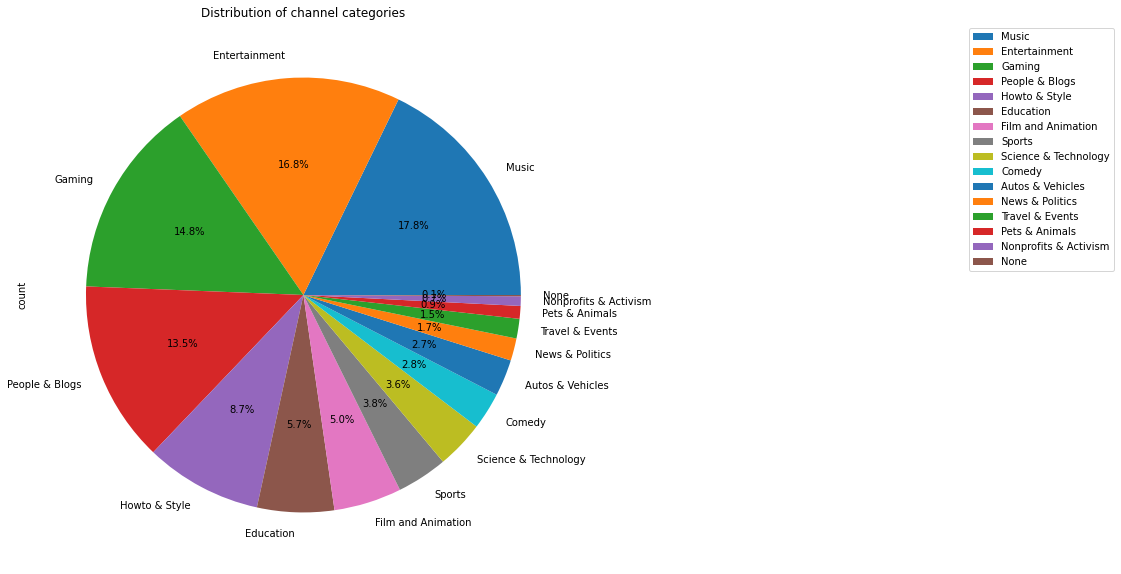

In [46]:
channel_per_category = chan_per_cat.set_index('category_e')
channel_per_category.plot.pie( y='count', figsize=(10, 10), autopct='%0.1f%%')
plt.title("Distribution of channel categories")
plt.legend(loc='upper right', bbox_to_anchor=(2.0, 1.0))
plt.show()

### Video statistics

#### Queries & computations

In [8]:
query_video_cnt = "select count(video_id) from video_metadata"
video_cnt = pd.read_sql_query(query_video_cnt,con=conn)
video_cnt

,count
0,72924794


In [10]:
query_gaming_vid_cnt2 = """
select count(video_id) from video_metadata video inner join 
(select channel from df_channels_en  where category_e = 'Gaming') gaming
on video.channel_id = gaming.channel"""

gaming_vid_cnt2 = pd.read_sql_query(str(query_gaming_vid_cnt2), con=conn)
gaming_vid_cnt2

,count
0,14168555


In [11]:
query_gaming_vid_cnt = "select count(*) from video_metadata where category_e = 'Gaming';"

gaming_vid_cnt = pd.read_sql_query(str(query_gaming_vid_cnt), con=conn)
gaming_vid_cnt

,count
0,13720303


In [12]:
query_politics_vid_cnt2 = """select count(video_id) from video_metadata video inner join
(select channel from df_channels_en  where category_e = 'News & Politics') politics
on video.channel_id = politics.channel;"""

politics_vid_cnt2 = pd.read_sql_query(query_politics_vid_cnt2,con=conn)
politics_vid_cnt2

,count
0,9503610


In [13]:
query_politics_vid_cnt = "select count(*) from video_metadata where category_e = 'News & Politics';"

politics_vid_cnt = pd.read_sql_query(query_politics_vid_cnt,con=conn)
politics_vid_cnt

,count
0,8881022


In [14]:
query_politics_vid_distr2 = """select channel_id, count(video_id) from video_metadata video inner join
(select channel from df_channels_en  where category_e = 'News & Politics') politics
on video.channel_id = politics.channel
group by video.channel_id;"""

politics_vid_distr2 = pd.read_sql_query(query_politics_vid_distr2,con=conn)
politics_vid_distr2

,channel_id,count
0,UC-0tjhOYNITmYenKykN1d5A,175
1,UC-2MJlKSq9_pYk5-bdvMhnw,2594
2,UC-3jIAlnQmbbVMV6gR7K8aQ,13135
3,UC-6DpdmxyEh6oPQb0gVKMiQ,998
4,UC-7vnmA1Zf1cRyqs9aR77ag,1733
...,...,...
2258,UCzhtAFR4aiLOr8IWqA92-5w,10591
2259,UCzmDDWDw9N7aB5Q9IWvQKfw,1945
2260,UCztSIZEGBfWfC3Mq63QXnsA,6296
2261,UCzuqE7-t13O4NIDYJfakrhw,8611


In [15]:
query_politics_vid_distr = "select channel_id,count(video_id) from video_metadata where category_e = 'News & Politics' group by channel_id"

politics_vid_distr = pd.read_sql_query(query_politics_vid_distr,con=conn)
politics_vid_distr

,channel_id,count
0,UC--3c8RqSfAqYBdDjIG3UNA,1
1,UC--jxlaAvQBLXKkvxecF8qQ,156
2,UC-07j8SBVA5mHbiNWe2-jcw,1
3,UC-0lQDT3mf_-HNC3hbD23Iw,1
4,UC-0tjhOYNITmYenKykN1d5A,75
...,...,...
11329,UCzyuclWm7yANjLYP4vlcleg,7
11330,UCzyuszXJUbY6w-S_t3n7hNQ,1
11331,UCzzKrtcSbLq28-JuTfYmZDg,200
11332,UCzzLIhDbFYU46T4VFBz_m_g,4


In [16]:
query_gaming_vid_distr2 = """select channel_id, count(video_id) from video_metadata video inner join
(select channel from df_channels_en  where category_e = 'Gaming') gaming
on video.channel_id = gaming.channel
group by video.channel_id"""

gaming_vid_distr2 = pd.read_sql_query(query_gaming_vid_distr2,con = conn)
gaming_vid_distr2

,channel_id,count
0,UC--7oyGW0N7fMf164-ZXljQ,205
1,UC--b720KocplK9zh0peruqg,38
2,UC--vL4ZYLa0bi3TQcuwrhoA,23
3,UC-05oNebNywp5jy7iXZWZzA,332
4,UC-0Wg1wOUp-bRF1ZiC0dE8g,1152
...,...,...
20138,UCzyu0YDMQB_5iSGPOXECcHQ,10
20139,UCzz9_nzdbrxnErTZPZdZ-cw,317
20140,UCzzHicLcWJP2jagxpqebzsA,133
20141,UCzzSPRyMYUw6IGueHr1K0Jg,519


In [17]:
query_gaming_vid_distr = "select channel_id,count(video_id) from video_metadata where category_e = 'Gaming' group by channel_id"
gaming_vid_distr = pd.read_sql_query(query_gaming_vid_distr,con=conn)
gaming_vid_distr

,channel_id,count
0,UC--2EbuIuBOGgGqPiJxi3rg,2
1,UC--7oyGW0N7fMf164-ZXljQ,160
2,UC--SaadDxRXz729rtbQqyBA,1
3,UC--b720KocplK9zh0peruqg,37
4,UC--oOv_2PpzwK4WNsjG2UAw,4
...,...,...
33136,UCzzLIhDbFYU46T4VFBz_m_g,1
33137,UCzzSPRyMYUw6IGueHr1K0Jg,409
33138,UCzzXikQ7B6ZCcmOYceFdumg,129
33139,UCzzYnZ8GIzfB1Vr3hk2Nj9Q,1


In [18]:
query_vid_per_cat2 = """select categories.category_e, count(video_id) from video_metadata video inner join
(select category_e, channel from df_channels_en) categories
on video.channel_id = categories.channel
group by categories.category_e
order by count(video_id) desc"""

vid_per_cat2 = pd.read_sql_query(query_vid_per_cat2,con=conn)
vid_per_cat2

,category_e,count
0,Gaming,14168555
1,Entertainment,12628972
2,News & Politics,9503610
3,Music,8523382
4,People & Blogs,5553837
5,Sports,4341527
6,Education,4027635
7,Howto & Style,3963876
8,Science & Technology,2466984
9,Autos & Vehicles,2294117


In [19]:
query_vid_per_cat = "select category_e, count(video_id) from video_metadata group by category_e order by count(video_id) desc"
vid_per_cat = pd.read_sql_query(query_vid_per_cat,con=conn)
vid_per_cat

,category_e,count
0,Gaming,13720303
1,Entertainment,12276397
2,News & Politics,8881022
3,Music,8305003
4,People & Blogs,6910666
5,Sports,4354412
6,Howto & Style,3968127
7,Education,3795564
8,Science & Technology,2403004
9,Film and Animation,2359736


In [20]:
# variables computation from dataframe
video_count = video_cnt["count"][0]
gaming_video_count = gaming_vid_cnt["count"][0]
politics_video_count = politics_vid_cnt["count"][0]
gaming_channel_video_count = gaming_vid_cnt2["count"][0]
politics_channel_video_count = politics_vid_cnt2["count"][0]

mean_gaming_video_distr = gaming_vid_distr["count"].mean()
mean_politics_video_distr = politics_vid_distr["count"].mean()
mean_gaming_channel_video_distr = gaming_vid_distr2["count"].mean()
mean_politics_channel_video_distr = politics_vid_distr2["count"].mean()

#### Results

In [21]:
print(f'There are {video_count} videos in our dataset')
print(f'{(gaming_channel_video_count / video_count)*100:.2f}% of them are from gaming channels ({gaming_channel_video_count} videos)')
print(f'{(politics_channel_video_count / video_count)*100:.2f}% of them are from news/politics channels ({politics_channel_video_count} videos)')
print(f'{(gaming_video_count / video_count)*100:.2f}% of them are gaming videos ({gaming_video_count} videos)')
print(f'{(politics_video_count / video_count)*100:.2f}% of them are news/politics videos ({politics_video_count} videos)')

There are 72924794 videos in our dataset
19.43% of them are from gaming channels (14168555 videos)
13.03% of them are from news/politics channels (9503610 videos)
18.81% of them are gaming videos (13720303 videos)
12.18% of them are news/politics videos (8881022 videos)


In [22]:
print(f'News/politics channels have an average of {mean_gaming_channel_video_distr:.2f} videos per channel --> see graph for full distribution')
print(f'Gaming channels have an average of {mean_politics_channel_video_distr:.2f} videos per channel --> see graph for full distribution')
print(f'Channels who post gaming videos post an average of {mean_gaming_video_distr:.2f} gaming videos per channel --> see graph for full distribution')
print(f'Channels who post news/politics videos post an average of {mean_politics_video_distr:.2f} news/politics videos per channel --> see graph for full distribution')

News/politics channels have an average of 703.40 videos per channel --> see graph for full distribution
Gaming channels have an average of 4199.56 videos per channel --> see graph for full distribution
Channels who post gaming videos post an average of 414.00 gaming videos per channel --> see graph for full distribution
Channels who post news/politics videos post an average of 783.57 news/politics videos per channel --> see graph for full distribution


#### Graphs

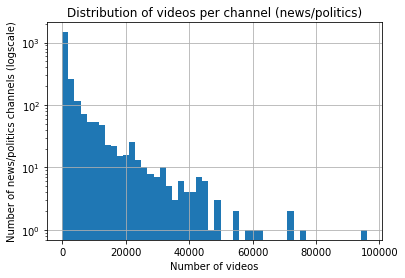

In [30]:
politics_vid_distr2["count"].hist(bins = 50)
plt.yscale('log')
plt.xlabel("Number of videos")
plt.ylabel("Number of news/politics channels (logscale)")
plt.title("Distribution of videos per channel (news/politics)")
plt.show()

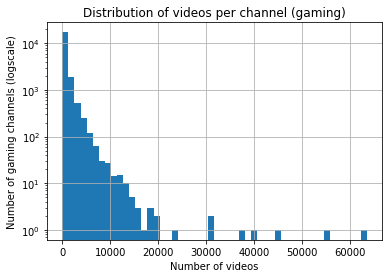

In [31]:
gaming_vid_distr2["count"].hist(bins = 50)
plt.yscale('log')
plt.xlabel("Number of videos")
plt.ylabel("Number of gaming channels (logscale)")
plt.title("Distribution of videos per channel (gaming)")
plt.show()

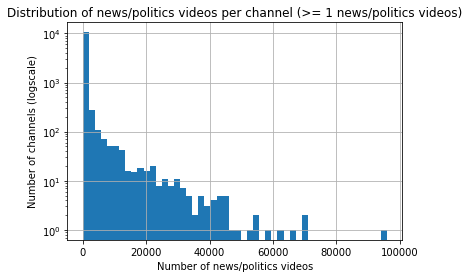

In [36]:
politics_vid_distr["count"].hist(bins = 50)
plt.yscale('log')
plt.xlabel("Number of news/politics videos")
plt.ylabel("Number of channels (logscale)")
plt.title("Distribution of news/politics videos per channel (>= 1 news/politics videos)")
plt.show()

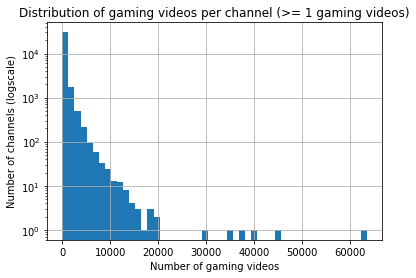

In [37]:
gaming_vid_distr["count"].hist(bins = 50)
plt.yscale('log')
plt.xlabel("Number of gaming videos")
plt.ylabel("Number of channels (logscale)")
plt.title("Distribution of gaming videos per channel (>= 1 gaming videos)")
plt.show()

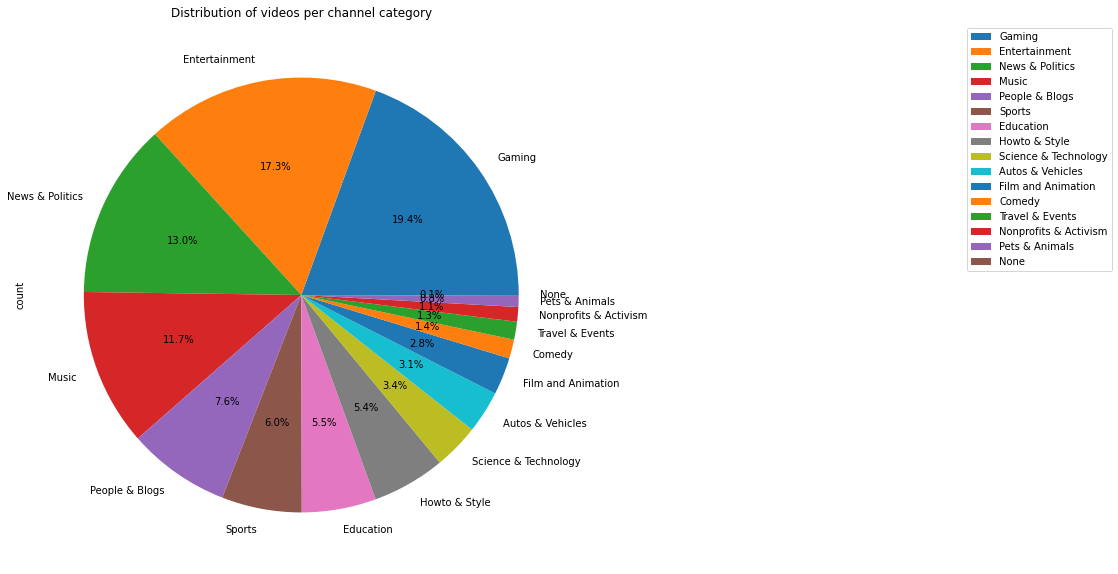

In [38]:
videos_per_channel_category = vid_per_cat2.set_index('category_e')
videos_per_channel_category.plot.pie( y='count', figsize=(10, 10), autopct='%0.1f%%')
plt.title("Distribution of videos per channel category")
plt.legend(loc='upper right', bbox_to_anchor=(2.0, 1.0))
plt.show()

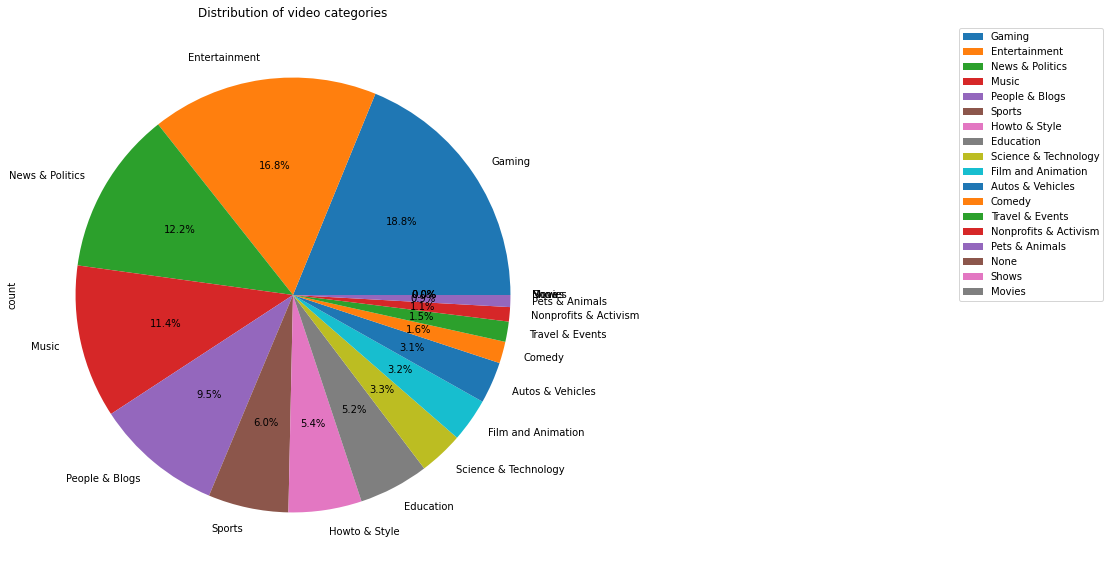

In [39]:
videos_per_category = vid_per_cat.set_index('category_e')
videos_per_category.plot.pie( y='count', figsize=(10, 10), autopct='%0.1f%%')
plt.title("Distribution of video categories")
plt.legend(loc='upper right', bbox_to_anchor=(2.0, 1.0))
plt.show()

### Comment statistics

#### Queries & computations

In [ ]:
query_est_comment_cnt = """SELECT (reltuples / relpages * (pg_relation_size(oid) / 8192))::bigint
FROM   pg_class
WHERE  oid = 'youtube_comments'::regclass;"""

est_comment_cnt = pd.read_sql_query(query_est_comment_cnt,con=conn)
est_comment_cnt 

In [21]:
query_comment_cnt = "select count(*) from youtube_comments"

comment_cnt = pd.read_sql_query(query_comment_cnt,con=conn)
comment_cnt

,count
0,8605619227


In [23]:
query_politics_comments_cnt = "select count(*) from video_metadata m, youtube_comments c where m.video_id=c.video_id and m.category_e='News & Politics';"
politics_comments_cnt = pd.read_sql_query(query_politics_comments_cnt,con=conn)
politics_comments_cnt

,count
0,413077730


In [24]:
query_gaming_comments_cnt = "select count(*) from video_metadata m, youtube_comments c where m.video_id=c.video_id and m.category_e='Gaming';"
gaming_comments_cnt = pd.read_sql_query(query_gaming_comments_cnt,con=conn)
gaming_comments_cnt

,count
0,2212472843


In [56]:
# takes a very long time
query_cat_comment_cnt = "select count(*),category_e from video_metadata vm inner join youtube_comments yc on yc.video_id = vm.video_id group by category_e;"
cat_comment_cnt = pd.read_sql_query(query_cat_comment_cnt,con=conn)
cat_comment_cnt

KeyboardInterrupt: KeyboardInterrupt: 

In [13]:
# Maybe this is faster but does not work very well
var_query = "select count(*) from video_metadata m, youtube_comments c where m.video_id=c.video_id and m.category_e="
cat_comment_cnt = {e: pd.read_sql_query(var_query + "'" + e + "'",con=conn) for e in categories['unnest']}
cat_comment_cnt = pd.DataFrame(cat_comment_cnt)
cat_comment_cnt 

KeyboardInterrupt: KeyboardInterrupt: 

In [16]:
query_gaming_comment_distr = "select m.video_id, m.view_count, count(*) from video_metadata m, youtube_comments c where m.video_id=c.video_id and m.category_e='Gaming' group by m.video_id, m.view_count;"
gaming_comment_distr = pd.read_sql_query(query_gaming_comment_distr, con=conn)
gaming_comment_distr

,video_id,view_count,count
0,---3x4oEKwc,101722,192
1,---4x0R56gs,370183,1973
2,---5GiCcDc8,9426,47
3,---8boO9Yro,101773,221
4,---9fXPL4hg,161190,266
...,...,...,...
5507956,zzze5NYtzYk,118331,405
5507957,zzzjubCIkAo,164354,184
5507958,zzznQgVW_-E,159596,525
5507959,zzzv8q_p7uM,36786,82


In [17]:
query_politics_comment_distr = "select m.video_id, m.view_count, count(*) from video_metadata m, youtube_comments c where m.video_id=c.video_id and m.category_e='News & Politics' group by m.video_id, m.view_count;"
politics_comment_distr= pd.read_sql_query(query_politics_comment_distr,con=conn)
politics_comment_distr

,video_id,view_count,count
0,5t2dBYaknpQ,6461.0,51
1,r_tbBKTjEmI,8326.0,58
2,IiNpZpwG85E,483022.0,381
3,jIfVh1UvSYQ,7064.0,64
4,IZ0RvvNyFhU,1233.0,34
...,...,...,...
1155248,8khe-n5lI-4,17918.0,220
1155249,NE1f1vfaZDI,13031.0,176
1155250,9U4ZvTLp108,5786.0,75
1155251,O-NfPavSoaE,16928.0,124


In [25]:
# variables computation from dataframe
nb_comments = comment_cnt["count"][0]
nb_politics_comments = politics_comments_cnt["count"][0]
nb_gaming_comments = gaming_comments_cnt["count"][0]

#### Results

In [26]:
print(f'There are {nb_comments} comments in the databse')
print(f'{nb_gaming_comments / nb_comments * 100:.2f}% of them are on gaming videos ({nb_gaming_comments} comments)')
print(f'{nb_politics_comments / nb_comments * 100:.2f}% of them are on news/politics videos ({nb_politics_comments} comments)')

There are 8605619227 comments in the databse
25.71% of them are on gaming videos (2212472843 comments)
4.80% of them are on news/politics videos (413077730 comments)


In [27]:
print(f'News/politics videos get {politics_comment_distr["count"].mean()} comments on average --> see graph for full distribution')
print(f'Gaming videos get {gaming_comment_distr["count"].mean()} comments on average --> see graph for full distribution')

News/politics videos get 357.5647325737306 comments on average --> see graph for full distribution
Gaming videos get 401.68636687877785 comments on average --> see graph for full distribution


In [28]:
print(f'News/politics videos get an average of {(politics_comment_distr["count"]/politics_comment_distr["view_count"]).mean()} comments per view --> see graph for full distribution')
print(f'Gaming videos get an average of {(gaming_comment_distr["count"]/gaming_comment_distr["view_count"]).mean()} comments per view --> see graph for full distribution')

News/politics videos get an average of 0.010462540855331793 comments per view --> see graph for full distribution
Gaming videos get an average of 0.00937300321830982 comments per view --> see graph for full distribution


#### Graphs

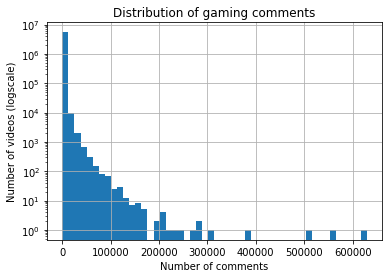

In [29]:
gaming_comment_distr["count"].hist(bins = 50)
plt.yscale('log')
plt.xlabel("Number of comments")
plt.ylabel("Number of videos (logscale)")
plt.title("Distribution of gaming comments")
plt.show()

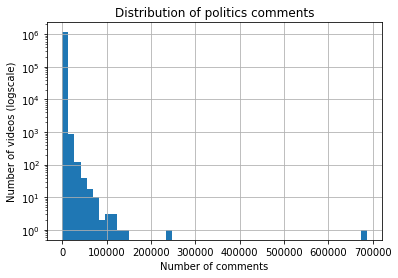

In [30]:
politics_comment_distr["count"].hist(bins = 50)
plt.yscale('log')
plt.xlabel("Number of comments")
plt.ylabel("Number of videos (logscale)")
plt.title("Distribution of politics comments")
plt.show()

### Viewer (commenter) statistics

#### Queries and computations

In [31]:
query_commenter_cnt = "select count(*) from (select distinct author from youtube_comments) a;"

commenter_cnt = pd.read_sql_query(query_commenter_cnt,con=conn)
commenter_cnt

,count
0,448810483


In [35]:
query_politics_channel_commenter_cnt = """select count(distinct author) from youtube_comments comments inner join
(select video_id, channel_id from video_metadata) videos
on videos.video_id = comments.video_id
inner join (select channel from df_channels_en where category_e = 'News & Politics') politics
on videos.channel_id = politics.channel;"""
politics_channel_commenter_cnt = pd.read_sql_query(query_politics_channel_commenter_cnt,con=conn)
politics_channel_commenter_cnt

,count
0,38884761


In [36]:
query_gaming_channel_commenter_cnt = """select count(distinct author) from youtube_comments comments inner join
(select video_id, channel_id from video_metadata) videos
on videos.video_id = comments.video_id
inner join (select channel from df_channels_en where category_e = 'Gaming') gaming
on videos.channel_id = gaming.channel"""
gaming_channel_commenter_cnt = pd.read_sql_query(query_gaming_channel_commenter_cnt,con=conn)
gaming_channel_commenter_cnt

,count
0,136168117


In [37]:
query_gaming_video_commenter_cnt = """select count(distinct author) from youtube_comments comments inner join
(select video_id, category_e from video_metadata where category_e = 'Gaming') videos
on videos.video_id = comments.video_id"""
gaming_video_commenter_cnt = pd.read_sql_query(query_gaming_video_commenter_cnt,con=conn)
gaming_video_commenter_cnt

,count
0,134928674


In [ ]:
query_politics_video_commenter_cnt = """select count(distinct author) from youtube_comments comments inner join
(select video_id, category_e from video_metadata where category_e = 'News & Politics') videos
on videos.video_id = comments.video_id"""
politics_video_commenter_cnt = pd.read_sql_query(query_politics_video_commenter_cnt,con=conn)
politics_video_commenter_cnt

In [ ]:
# variables computation from dataframe
nb_commenters = commenter_cnt["count"][0]
nb_politics_video_commenters = politics_video_commenter_cnt["count"][0]
nb_gaming_video_commenters = gaming_video_commenter_cnt["count"][0]
nb_politics_channel_commenters = politics_channel_commenter_cnt["count"][0]
nb_gaming_channel_commenters = gaming_channel_commenter_cnt["count"][0]

#### Results

In [33]:
print(f'There are {nb_commenters} unique commenters')
print(f'{(nb_politics_video_commenters / nb_commenters)*100:.2f}% of them commented on a news/politics video ({nb_politics_video_commenters} viewers)')
print(f'{(nb_gaming_video_commenters / nb_commenters)*100:.2f}% of them commented on a gaming video ({nb_gaming_video_commenters} viewers)')
print(f'{(nb_politics_channel_commenters / nb_commenters)*100:.2f}% of them commented on a video from a news/politics channel ({nb_politics_channel_commenters} viewers)')
print(f'{(nb_gaming_channel_commenters / nb_commenters)*100:.2f}% of them commented on a video from a gaming channel ({nb_gaming_channel_commenters} viewers)')

NameError: NameError: name 'nb_commenters' is not defined

In [ ]:
#These queries will probalby turn out quite expensive which is why we left them out for now
print(f'{}% of them commented on both ({} viewers)')
print(f'{}% of them only comment on gaming channels ({} viewers)')
print(f'{}% of them only comment on news/politics channels ({} viewers)')

In [ ]:
#These queries will probably turn out to be quite expensive which is why we left them out for now
print('Restricted to gaming and news/politics videos : ')
print(f'A commenter posts {} comments on average --> see graphs for full distribution')
print(f'A commenter posts on {} different channels on average --> see graph for full distribution')

#### Graphs